In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
exhaustive = open("A_WLreferenceCAT.sgems", 'r')
train = open("C_WLTICAT.sgems", 'r')
test = open("B_WLCATsamples.sgems", 'r')

In [3]:
exhaustive = exhaustive.readlines()
train = train.readlines()
test = test.readlines()

In [4]:
exhaustive = list(map(lambda x:x.strip(), exhaustive))
train = list(map(lambda x:x.strip(), train))
test = list(map(lambda x:x.strip(), test))

In [5]:
Y, X, Z = list(map(int, exhaustive[0].split()))

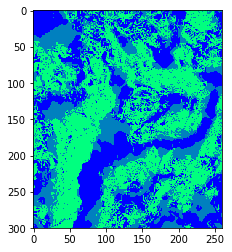

In [6]:
exhaustive_image = np.zeros((X, Y)).astype(np.int)
count = 3
array = []
for i in range(X):
    for j in range(Y):
        exhaustive_image[i][j] = int(exhaustive[count])+1
        array.append([i, j, exhaustive_image[i][j]])
        count += 1
plt.imshow(exhaustive_image/np.max(exhaustive_image), cmap="winter")
plt.show()
array = np.array(array)

In [7]:
exhaustive_data = pd.DataFrame({'X':array[:, 0], 'Y':array[:, 1], 'var':array[:, 2]})

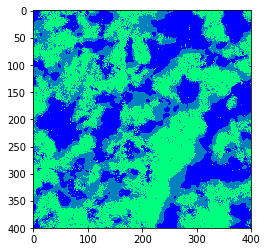

In [8]:
train_Y, train_X, train_Z = list(map(int, train[0].split()))
count = 3
train_image = np.zeros((train_X, train_Y)).astype(np.int)
for i in range(train_X):
    for j in range(train_Y):
        train_image[i][j] = int(train[count])+1
        count += 1
plt.imshow(train_image/np.max(train_image), cmap="winter")
plt.show()

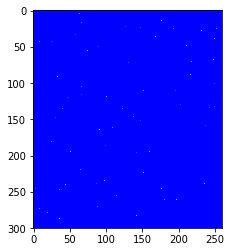

In [9]:
test_image = np.zeros((X, Y)).astype(np.int)
array = []
for i in range(int(test[0])):
    y, x, _, var = list(map(int, test[i+6].split()))
    array.append([x, y, var+1])
    test_image[x][y] = var+1
plt.imshow(test_image, cmap="winter")
plt.show()
array = np.array(array)

In [10]:
test_data = pd.DataFrame({'X':array[:, 0], 'Y':array[:, 1], 'var':array[:, 2]})

In [11]:
def range_xy(sill, X, Y):
  percent95 = 0.95*sill
  for i in range(len(X)):
    if(Y[i] >= percent95):
      return X[i]
  return X[-1]

def spherical_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z[(Z.index<=a)]=nugget+(sill-nugget)*(1.5*Z/a-0.5*np.power(Z/a,3))
  Z[(Z.index>a)]=sill
  return np.array(Z)
    
def exponential_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z=nugget+(sill-nugget)*(1-np.exp(-3*Z/a))
  return np.array(Z)
  
  
def gaussian_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z=nugget+(sill-nugget)*(1-np.exp(-3*np.square(Z)/np.square(a)))
  return np.array(Z)

def mean_absolute_percentage_error(data, gold_grade='gold_grade', estimate='estimate'):
  error_series = (data.apply(lambda row: np.abs((row.gold_grade - row.estimate)/row.gold_grade), axis=1))
  return error_series.sum()*100/len(error_series)

from collections import defaultdict
def variogram(data, X = "X", Y = "Y", G="gold_grade", min_angle=0, angle_tolerance=90, no_of_lags = 10, lag_spacing=10, lag_tolerance=5):
    g_values = pd.DataFrame({'distance':[] , 'values':[]})
    x_y_values = defaultdict(lambda:0)
    count = defaultdict(lambda:0)
    for i in range(data.shape[0]):
        if(angle_tolerance >= 90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        elif(min_angle+angle_tolerance > 90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (~((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi > min_angle+angle_tolerance-180) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi < min_angle-angle_tolerance))) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        elif(min_angle-angle_tolerance < -90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (~((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi > min_angle+angle_tolerance) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi < 180+min_angle-angle_tolerance))) &(np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        else:
            var_data = pd.DataFrame(np.array(data[(data.index > i) & ((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi >= min_angle-angle_tolerance) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi <= min_angle+angle_tolerance)) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        var_data[X] -= data[X][i]
        var_data[Y] -= data[Y][i]
        var_data["distance"] = np.linalg.norm(var_data[[X, Y]], axis=1)
        var_data = var_data.drop(columns=[X, Y])
        var_data["values"] = var_data["values"] - data[G][i]
        g_values = g_values.append(var_data, ignore_index = True, sort=False)
        if(i%100 == 0):
            for j in range(0, no_of_lags*lag_spacing+1, lag_spacing):
                range_array = np.array(g_values[(g_values['distance']>j-lag_tolerance) & (g_values['distance'] <= j+lag_tolerance)]['values'])
                x_y_values[j] += np.sum(np.square(range_array), axis = 0)
                count[j] += range_array.shape[0]
            g_values = pd.DataFrame({'distance':[] , 'values':[]}) 
    x = []
    y = []
    for keys in x_y_values:
        x.append(keys)
        y.append(x_y_values[keys]/(2*count[keys]))
    return(x, y)

Text(0.5, 1.0, 'Variogram')

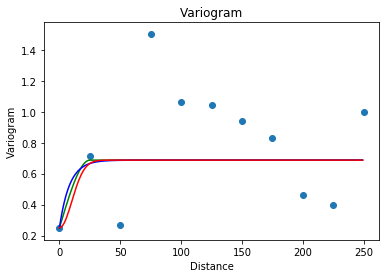

In [12]:
[X, Y] = variogram(test_data, no_of_lags=10, G='var', lag_spacing = 25, lag_tolerance = 15)
plt.scatter(X, Y)
plt.plot(spherical_model(test_data, X, Y,label='var'), 'g-')
plt.plot(exponential_model(test_data, X, Y,label='var'), 'b-')
plt.plot(gaussian_model(test_data, X, Y, label='var'), 'r-')
plt.xlabel("Distance")
plt.ylabel("Variogram")
plt.title("Variogram")

In [13]:
def covariance_function(nugget, sill, distance, a, model = "spherical"):
  if(model == "spherical"):
    return ((sill-nugget)*(1-1.5*distance/a+0.5*np.power(distance/a,3)))
  elif(model == "gaussian"):
    return ((sill-nugget)*(np.exp(-3*np.square(distance)/np.square(a))))
  elif(model == "exponential"):
    return ((sill-nugget)*(np.exp(-3*distance/a)))
  
count = 0
    
def find_estimate(data, x, y, nugget, a, X='X', Y='Y', G='gold_grade', model="spherical", max_points=4, kriging_type="ordinary"):
  points = pd.DataFrame({X:[], Y:[], G:[] , 'distance':[]})
  df1 = pd.DataFrame(np.array(data[(data[X] >= x) & (data[Y] >= y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] > x) & (data[Y] < y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] < x) & (data[Y] < y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] < x) & (data[Y] > y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  distances = pd.merge(pd.DataFrame({'key':1, 'X1':points[X], 'Y1':points[Y]}), pd.DataFrame({'key':1, 'X2':points[X], 'Y2':points[Y]}))
  distances['distance'] = np.sqrt(np.square(distances['X1']-distances['X2'])+np.square(distances['Y1']-distances['Y2']))
  dist_length = len(distances)
  if(kriging_type == "ordinary"):
    self_cov_matrix = np.pad(covariance_function(nugget, (data[G]).var(), np.array(points['distance']),  a, model), (0,1), 'constant', constant_values=(0, 1))
  elif(kriging_type == "block"):
    block_points = (pd.merge(pd.DataFrame({"key":1, "X":np.array(range(int(x)-50,int(x)+50))}), pd.DataFrame({"key":1, "Y":np.array(range(int(y)-50,int(y)+50))}), on='key'))
    b_shape = block_points.shape[0]
    p_shape = points.shape[0]
    block_points = (pd.merge(pd.DataFrame({"key":1, "X1":block_points[X], "Y1":block_points[Y]}), pd.DataFrame({"key":1, "X2":points[X], "Y2":points[Y]}), on='key'))
    block_points["distance"] = block_points.apply(lambda row: np.sqrt(np.square(row.X1-row.X2)+np.square(row.Y1-row.Y2)), axis = 1)
    self_cov_matrix = np.pad(np.average(covariance_function(nugget, (data[G]).var(), np.array(block_points["distance"]).reshape(p_shape, b_shape), a, model), axis = 1), (0,1), 'constant', constant_values=(0, 1))
  cov_matrix = np.pad(covariance_function(nugget, (data[G]).var(), (np.array(distances['distance'])).reshape((int(np.sqrt(dist_length)), int(np.sqrt(dist_length)))), a, model), ((0, 1), (0, 1)), 'constant', constant_values=((0, 1), (0, 1)))
  cov_matrix[-1, -1] = 0
  #print(cov_matrix)
  #print(self_cov_matrix)
  #print(cov_matrix.shape)
  #print(self_cov_matrix.shape)
  weights = np.dot(np.linalg.inv(cov_matrix), self_cov_matrix) 
  #print(weights)
  #print(x, y)
  return min(max(1, np.dot(weights[:-1], np.array(points[G]))), 3)
  
  
  
def kriging(sample_train, sample_test, nugget, a, X='X', Y='Y', G='gold_grade', model="spherical", kriging_type="ordinary"):
  sample_test['estimate'] = sample_test.apply(lambda row: find_estimate(sample_train, row.X, row.Y, nugget, a, X, Y, G, kriging_type=kriging_type), axis=1)
  return sample_test
  
  

In [14]:
answers = kriging(test_data, exhaustive_data, Y[0], range_xy(test_data['var'].var(), X, Y), G='var')

In [15]:
answers

,X,Y,var,estimate
0,0,0,1,1.000000
1,0,1,1,1.000000
2,0,2,1,1.000000
3,0,3,1,1.000000
4,0,4,1,1.000000
5,0,5,1,1.000000
6,0,6,1,1.000000
7,0,7,1,1.000000
8,0,8,1,1.000000
9,0,9,1,3.000000


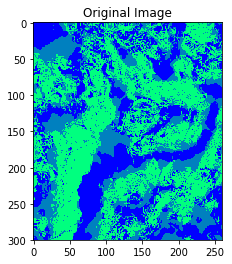

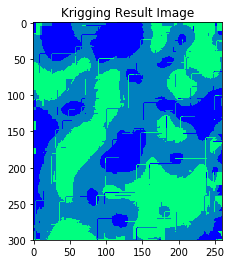

In [17]:
final_image = np.zeros(test_image.shape)
for _, row in answers.iterrows():
    final_image[int(row['X']), int(row['Y'])] = np.round(row['estimate'])
plt.imshow(exhaustive_image, cmap='winter')
plt.title('Original Image')
plt.figure()
plt.imshow(final_image, cmap='winter')
plt.title('Krigging Result Image')
plt.show()